Sequence-aware recommender system

In [1]:
import numpy as np
import warnings
import pandas as pd
from spmf import Spmf
from gensim.models import Word2Vec
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import LSTM
from keras.utils import np_utils
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from matplotlib import pyplot as plt

warnings.filterwarnings('ignore')
columns = ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 
                'UnitPrice', 'CustomerID', 'Country']
data = pd.read_csv('OnlineRetail.csv', sep=',', names=columns, engine='python')
data = data.drop(data.index[[0]])

# remove missing values
data = data[(data.Description.notnull()) & (data.Quantity.astype(int) > 0)]
# transform column to datetime
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
# reset row index
data = data.reset_index(drop=True)

data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


Transform transactions into lists of items

In [2]:
# filter transactions to get only transactions from the past month
max_date = data['InvoiceDate'].max()
filtered_data = data[(data.InvoiceDate <= max_date) & (data.InvoiceDate >= (max_date - pd.DateOffset(months=1)))]
transactions_array = []
transactions = filtered_data.groupby(['InvoiceNo'], as_index=False)['StockCode'].apply(list)
for i in range(0, len(transactions)):
    vals = ' '.join(transactions.values[i])
    transactions_array.append(vals)

transactions_array[:5]

['23544 21790 21791 22619',
 '23318 21136 23319 22809 22810 22739 22732 22141 22144 22142 23313 22910 23264 23265 23266 20668 21803 35471D 22952 23267 23101 23350 23351 23349 23352',
 '21888 22992 22561 23494',
 '47566 22693 22523 22522 21878 22568 22621 22865 22867 22652 23198 84987 84991 22938 23197',
 '22426 22962 22963 22227 22139 23147 16008 84347 82486 84510A 22753 22757 21380 15056BL 15056N 23031 23146 22411']

Method for getting recommendations from product's associations

In [3]:
def recommend(recent_products, associations):
    recommended = dict()
    for p in recent_products:
        for i in range(0, len(associations.pattern)):
            if((p in associations.pattern.values[i]) and
                    (associations.pattern.values[i].index(p) != (len(associations.pattern.values[i]) - 1))):
                ind = associations.pattern.values[i].index(p)
                if p not in recommended:
                    recommended[p] = []
                recommended[p].append([associations.pattern.values[i][ind + 1:], 
                                       associations.sup.values[i]])

    return recommended

Method for printing recommendations

In [4]:
def print_recommendations(recommended, products_dict, n):
    for r in recommended:
        print("Frequently bought with " + str(products_dict[r][0]) + " :\n")
        supports = dict()
        for p in recommended[r]:
            supports[tuple(p[0])] = p[1]
        sorted_supports = sorted(supports.items(), key=lambda x: x[1], reverse=True)

        if n > len(supports):
            m = len(supports)
        else:
            m = n
        
        for i in range(0, m):
            for y in sorted_supports[i][0]:
                print(str(products_dict[y][0]) + '\n')

Using GSP algorithm to find associations between products

In [5]:
result_GSP = Spmf("GSP", input_direct=transactions_array, input_type="text", arguments=[0.02],
                  output_filename='GSP_output.txt',
                  spmf_bin_location_dir='D:/Kristina/Documents/Master/BI/MLRecommenderSystem')
result_GSP.run()
df_GSP = result_GSP.to_pandas_dataframe(pickle=True)
df_GSP = df_GSP[df_GSP.pattern.str.len() > 1]
df_GSP.head()

>/D:/Kristina/Documents/Master/BI/MLRecommenderSystem/spmf.jar
Converting TEXT to SPMF format.
Conversion completed.
=============  Algorithm - STATISTICS =============
 Total time ~ 113682 ms
 Frequent sequences count : 484
 Max memory (mb):161.8193130493164

Post-processing to show result in terms of string values.
Post-processing completed.



,pattern,sup
431,"[21790, 21791]",60
432,"[22141, 22144]",77
433,"[22142, 22144]",60
434,"[22086, 22144]",63
435,"[22910, 22952]",62


Recommending similar products to user based on his latest interactions

In [6]:
session = ['85123A', '22835', '22086', '22910', '22577']
recent_products = session[-3:]

# create product-ID and product-description dictionary
products_dict = filtered_data.groupby('StockCode')['Description'].apply(list).to_dict()

# get itemsets that contain products from current session
filtered_GSP = df_GSP[df_GSP.pattern.map(lambda x: np.isin(x, recent_products).any())]

recommended = recommend(recent_products, filtered_GSP)

filtered_GSP.head()

,pattern,sup
434,"[22086, 22144]",63
435,"[22910, 22952]",62
436,"[22910, 23084]",79
437,"[22910, 22086]",80
438,"[22086, 22910]",142


In [7]:
print_recommendations(recommended, products_dict, 3)

Frequently bought with PAPER CHAIN KIT 50'S CHRISTMAS  :

PAPER CHAIN KIT VINTAGE CHRISTMAS

RABBIT NIGHT LIGHT

GARDENERS KNEELING PAD KEEP CALM 

Frequently bought with PAPER CHAIN KIT VINTAGE CHRISTMAS :

PAPER CHAIN KIT 50'S CHRISTMAS 

RABBIT NIGHT LIGHT

GARDENERS KNEELING PAD KEEP CALM 

Frequently bought with WOODEN HEART CHRISTMAS SCANDINAVIAN :

WOODEN STAR CHRISTMAS SCANDINAVIAN

WOODEN TREE CHRISTMAS SCANDINAVIAN



Using PrefixSpan algorithm to find associations between products

In [8]:
result_PrefixSpan = Spmf("PrefixSpan", input_direct=transactions_array, input_type="text", arguments=[0.02],
                         output_filename='PS_output.txt',
                         spmf_bin_location_dir='D:/Kristina/Documents/Master/BI/MLRecommenderSystem')
result_PrefixSpan.run()
df_PrefixSpan = result_PrefixSpan.to_pandas_dataframe(pickle=True)
df_PrefixSpan = df_PrefixSpan[df_PrefixSpan.pattern.str.len() > 1]
df_PrefixSpan.head()

>/D:/Kristina/Documents/Master/BI/MLRecommenderSystem/spmf.jar
Converting TEXT to SPMF format.
Conversion completed.
=============  PREFIXSPAN 0.99-2016 - STATISTICS =============
 Total time ~ 156 ms
 Frequent sequences count : 484
 Max memory (mb) : 70.09880065917969
 minsup = 59 sequences.
 Pattern count : 484

Post-processing to show result in terms of string values.
Post-processing completed.



,pattern,sup
1,"[21790, 21791]",60
10,"[22141, 22144]",77
13,"[22142, 22144]",60
16,"[22910, 22952]",62
17,"[22910, 23084]",79


In [9]:
# get itemsets that contain products from current session
filtered_PrefixSpan = df_PrefixSpan[df_PrefixSpan.pattern.map(lambda x: np.isin(x, recent_products).any())]

recommended = recommend(recent_products, filtered_PrefixSpan)

filtered_PrefixSpan.head()

,pattern,sup
16,"[22910, 22952]",62
17,"[22910, 23084]",79
18,"[22910, 22086]",80
19,"[22910, 23301]",63
59,"[22578, 22577]",67


In [10]:
print_recommendations(recommended, products_dict, 3)

Frequently bought with PAPER CHAIN KIT 50'S CHRISTMAS  :

PAPER CHAIN KIT VINTAGE CHRISTMAS

RABBIT NIGHT LIGHT

GARDENERS KNEELING PAD KEEP CALM 

Frequently bought with PAPER CHAIN KIT VINTAGE CHRISTMAS :

PAPER CHAIN KIT 50'S CHRISTMAS 

RABBIT NIGHT LIGHT

GARDENERS KNEELING PAD KEEP CALM 

Frequently bought with WOODEN HEART CHRISTMAS SCANDINAVIAN :

WOODEN STAR CHRISTMAS SCANDINAVIAN

WOODEN TREE CHRISTMAS SCANDINAVIAN



Using Prod2Vec for distributed product representation

In [11]:
transactions_array = []
transactions = data.groupby(['InvoiceNo'], as_index=False)['StockCode'].apply(list)
for i in range(0, len(transactions)):
    transactions_array.append(transactions.values[i])
 
transactions_array[:5]

[['85123A', '71053', '84406B', '84029G', '84029E', '22752', '21730'],
 ['22633', '22632'],
 ['84879',
  '22745',
  '22748',
  '22749',
  '22310',
  '84969',
  '22623',
  '22622',
  '21754',
  '21755',
  '21777',
  '48187'],
 ['22960', '22913', '22912', '22914'],
 ['21756']]

In [12]:
# train word2vec model
model = Word2Vec(window=10, sg=1, hs=0,
                 negative=10,
                 alpha=0.03, min_alpha=0.0007,
                 seed=14)

model.build_vocab(transactions_array, progress_per=200)

model.train(transactions_array, total_examples=model.corpus_count, epochs=10, report_delay=1)
model.init_sims(replace=True)

products = data[["StockCode", "Description"]]

# remove duplicates
products.drop_duplicates(inplace=True, subset='StockCode', keep="last")

# create product-ID and product-description dictionary
products_dict = data.groupby('StockCode')['Description'].apply(list).to_dict()

Method for finding similar products given an input product vector

In [13]:
def similar_products(v, n, session):   
    # extract most similar products for the input vector
    products = model.similar_by_vector(v, topn=n+1)[1:]
    
    # extract name and similarity score of the similar products
    most_similar_products = []
    for j in products:
        if j[0] not in session:
            pair = (products_dict[j[0]][0], j[1])
            most_similar_products.append(pair)
        
    return most_similar_products     

Method for aggregating products from session into single vector

In [14]:
def aggregate_vectors(products):
    product_vec = []
    for i in products:
        product_vec.append(model[i])
        
    return np.mean(product_vec, axis=0)

Recommending similar products based on products in current session

In [15]:
print("Similar products:\n")
recommended = similar_products(aggregate_vectors(session), 5, session)
for p in recommended:
    print(str(p[0]) + '\n')

Similar products:

SET OF 20 VINTAGE CHRISTMAS NAPKINS

BOX OF 6 MINI 50'S CRACKERS

JINGLE BELL HEART ANTIQUE SILVER



Using recurrent neural network to predict products for session continuation

In [16]:
filtered_data = data[(data.InvoiceDate <= max_date) & (data.InvoiceDate >= (max_date - pd.DateOffset(months=3)))]
transactions_array = []
transactions = filtered_data.groupby(['InvoiceNo'], as_index=False)['StockCode'].apply(list)
for i in range(0, len(transactions)):
    transactions_array.append(transactions.values[i])

products = filtered_data.StockCode.unique()
print("Number of unique products: " + str(len(products)))
products_to_int = dict((p, i) for i, p in enumerate(products, start=1))
int_to_products = dict((i, p) for i, p in enumerate(products, start=1))

seq_length = 3
dataX = []
dataY = []

for i in range(0, len(transactions_array)):
    for j in range(0, len(transactions_array[i]) - seq_length):
        seq_in = transactions_array[i][j:j + seq_length]
        seq_out = transactions_array[i][j + seq_length]
        dataX.append([products_to_int[prod] for prod in seq_in])
        dataY.append(products_to_int[seq_out])

print("Total number of sequences: " + str(len(dataX)))

# reshape X to be [samples, time steps, features]
X = np.reshape(dataX, (len(dataX), seq_length, 1))
# normalize values to be in range [0, 1]
X = X/float(len(products))

# make output categorical
y = np_utils.to_categorical(dataY)

Number of unique products: 3238
Total number of sequences: 185159


In [17]:
lstm_model = Sequential()
lstm_model.add(LSTM(150, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(80))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(y.shape[1], activation='softmax'))
opt = Adam(learning_rate=0.001)
lstm_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
h = lstm_model.fit(X, y, epochs=30, batch_size=100, validation_split=0.2, verbose=1)

Epoch 1/30
1482/1482 [==============================] - 27s 18ms/step - loss: 7.4335 - accuracy: 0.0037 - val_loss: 7.4724 - val_accuracy: 0.0048
Epoch 2/30
1482/1482 [==============================] - 19s 13ms/step - loss: 7.3342 - accuracy: 0.0046 - val_loss: 7.4607 - val_accuracy: 0.0047
Epoch 3/30
1482/1482 [==============================] - 22s 15ms/step - loss: 7.2951 - accuracy: 0.0048 - val_loss: 7.4202 - val_accuracy: 0.0057
Epoch 4/30
1482/1482 [==============================] - 19s 13ms/step - loss: 7.2519 - accuracy: 0.0057 - val_loss: 7.3890 - val_accuracy: 0.0066
Epoch 5/30
1482/1482 [==============================] - 19s 13ms/step - loss: 7.2138 - accuracy: 0.0065 - val_loss: 7.3700 - val_accuracy: 0.0072
Epoch 6/30
1482/1482 [==============================] - 18s 12ms/step - loss: 7.1791 - accuracy: 0.0071 - val_loss: 7.3618 - val_accuracy: 0.0082
Epoch 7/30
1482/1482 [==============================] - 18s 12ms/step - loss: 7.1471 - accuracy: 0.0078 - val_loss: 7.3549 -

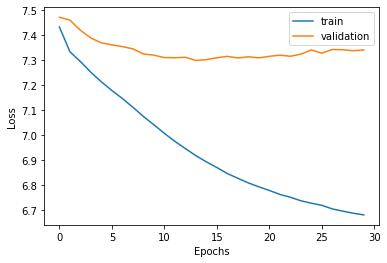

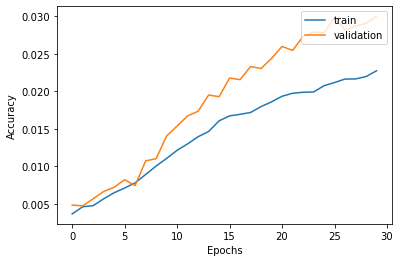

In [18]:
plt.plot(h.history['loss'], label='Train loss')
plt.plot(h.history['val_loss'], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()
plt.plot(h.history['accuracy'], label='Train accuracy')
plt.plot(h.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

Predicting next product(s) in session

In [19]:
session_enumerated = []
session_enumerated.append([products_to_int[prod] for prod in recent_products])
results = []

for i in range(3):
    x = np.reshape(session_enumerated, (1, seq_length, 1))
    x = x/float(len(products))
    prediction = lstm_model.predict(x, verbose=0)
    index = np.argmax(prediction)
    results.append(int_to_products[index])
    session_enumerated[0].append(index)
    session_enumerated[0] = session_enumerated[0][1:len(session_enumerated[0])]

print("Recommended products: \n")
for res in results:
    print(products_dict[res][0])

Recommended products: 

WOODEN STAR CHRISTMAS SCANDINAVIAN
WOODEN TREE CHRISTMAS SCANDINAVIAN
ADVENT CALENDAR GINGHAM SACK
